# 1. Imports & GPU Check

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pathlib
import os

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
GPU available: []


# 2. LOAD Dataset

In [4]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

train_dir = pathlib.Path("../data/train")
test_dir = pathlib.Path("../data/test")

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

class_names = train_ds.class_names
class_names

Found 23586 files belonging to 11 classes.
Found 5538 files belonging to 11 classes.


['acne',
 'basal_cell_carcinoma',
 'benign_keratosis',
 'eczema',
 'fungal',
 'melanocytic_nevi',
 'melanoma',
 'normal',
 'psoriasis',
 'seborrheic_keratosis',
 'warts']

# 3. Visualize Class Distribution

2025-11-24 17:53:02.320238: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


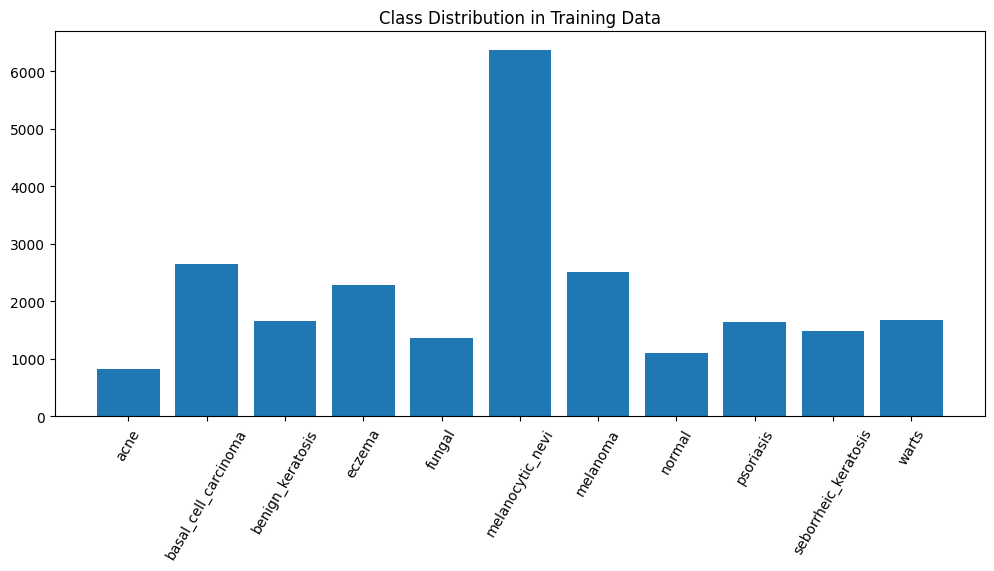

In [5]:
counts = {c: 0 for c in class_names}

for _, labels in train_ds:
    for idx in tf.argmax(labels, axis=1).numpy():
        counts[class_names[idx]] += 1

plt.figure(figsize=(12,5))
plt.bar(counts.keys(), counts.values())
plt.title("Class Distribution in Training Data")
plt.xticks(rotation=60)
plt.show()


# 4. Preprocessing & Data Augmentation

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
normalization_layer = tf.keras.layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
])

def prepare(ds, augment=False, shuffle=True):
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x, y: (normalization_layer(x), y),
                num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.prefetch(AUTOTUNE)

train_prep = prepare(train_ds, augment=True)
test_prep = prepare(test_ds, augment=False, shuffle=False)


# 5. Build Model (MobileNetV2 Transfer Learning)

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers

num_classes = len(class_names)

base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


/var/folders/2n/l7v6yt5s7qj2vn29y8bfz_br0000gn/T/ipykernel_11887/1725001483.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 11)             │        14,091 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,272,075 (8.67 MB)

 Trainable params: 14,091 (55.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# 6. Train Model

In [8]:
from sklearn.utils import class_weight
import numpy as np

# Extract all training labels
all_labels = []
for _, labels in train_ds:
    all_labels.extend(np.argmax(labels.numpy(), axis=1))

# Compute weights
cw = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

class_weights = {i: cw[i] for i in range(len(cw))}
class_weights

2025-11-24 17:53:44.982813: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{0: np.float64(2.6053242019220146),
 1: np.float64(0.8066899240714139),
 2: np.float64(1.2893456513420434),
 3: np.float64(0.9379623001670245),
 4: np.float64(1.5754458619998664),
 5: np.float64(0.33628949469601915),
 6: np.float64(0.8535755645628257),
 7: np.float64(1.9421936758893281),
 8: np.float64(1.3042468480424685),
 9: np.float64(1.4517141626146366),
 10: np.float64(1.274781104745433)}

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

MODEL_PATH = "../models/dermascan_base.h5"

callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ModelCheckpoint(MODEL_PATH, save_best_only=True)
]

history = model.fit(
    train_prep,
    validation_data=test_prep,
    epochs=25,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/25


2025-11-24 17:54:33.885866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 245 of 1000
2025-11-24 17:54:43.888908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 483 of 1000
2025-11-24 17:54:53.902388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 691 of 1000
2025-11-24 17:54:56.371771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.2664 - loss: 2.0783

738/738 ━━━━━━━━━━━━━━━━━━━━ 210s 231ms/step - accuracy: 0.3664 - loss: 1.7387 - val_accuracy: 0.3917 - val_loss: 1.5232
Epoch 2/25


2025-11-24 17:58:00.172554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 260 of 1000
2025-11-24 17:58:20.179881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 729 of 1000
2025-11-24 17:58:20.475501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.4951 - loss: 1.3114

738/738 ━━━━━━━━━━━━━━━━━━━━ 199s 225ms/step - accuracy: 0.5167 - loss: 1.2440 - val_accuracy: 0.5572 - val_loss: 1.1347
Epoch 3/25


2025-11-24 18:01:19.121953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 258 of 1000
2025-11-24 18:01:29.145900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 503 of 1000
2025-11-24 18:01:39.023247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.5646 - loss: 1.1220

738/738 ━━━━━━━━━━━━━━━━━━━━ 200s 227ms/step - accuracy: 0.5706 - loss: 1.0981 - val_accuracy: 0.6138 - val_loss: 0.9888
Epoch 4/25


2025-11-24 18:04:38.846262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 257 of 1000
2025-11-24 18:04:48.896745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 496 of 1000
2025-11-24 18:04:58.900188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 726 of 1000
2025-11-24 18:04:59.357672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.5911 - loss: 1.0344

738/738 ━━━━━━━━━━━━━━━━━━━━ 202s 231ms/step - accuracy: 0.5923 - loss: 1.0358 - val_accuracy: 0.6401 - val_loss: 0.9154
Epoch 5/25


2025-11-24 18:08:01.186315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 257 of 1000
2025-11-24 18:08:11.210014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 497 of 1000
2025-11-24 18:08:21.220760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 726 of 1000
2025-11-24 18:08:21.765449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.6102 - loss: 0.9918

738/738 ━━━━━━━━━━━━━━━━━━━━ 198s 225ms/step - accuracy: 0.6126 - loss: 0.9917 - val_accuracy: 0.6576 - val_loss: 0.8811
Epoch 6/25


2025-11-24 18:11:19.201703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 260 of 1000
2025-11-24 18:11:39.199036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 731 of 1000
2025-11-24 18:11:39.375162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.6305 - loss: 0.9454

738/738 ━━━━━━━━━━━━━━━━━━━━ 198s 225ms/step - accuracy: 0.6336 - loss: 0.9436 - val_accuracy: 0.6629 - val_loss: 0.8574
Epoch 7/25


2025-11-24 18:14:37.260175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 256 of 1000
2025-11-24 18:14:47.280722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 500 of 1000
2025-11-24 18:14:57.256475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.6343 - loss: 0.9443

738/738 ━━━━━━━━━━━━━━━━━━━━ 198s 226ms/step - accuracy: 0.6443 - loss: 0.9154 - val_accuracy: 0.6753 - val_loss: 0.8299
Epoch 8/25


2025-11-24 18:17:54.811321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 257 of 1000
2025-11-24 18:18:14.857874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 731 of 1000
2025-11-24 18:18:15.070955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6510 - loss: 0.8895

738/738 ━━━━━━━━━━━━━━━━━━━━ 197s 223ms/step - accuracy: 0.6523 - loss: 0.8859 - val_accuracy: 0.6800 - val_loss: 0.8174
Epoch 9/25


2025-11-24 18:21:12.308275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 260 of 1000
2025-11-24 18:21:22.326892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 503 of 1000
2025-11-24 18:21:32.124588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6640 - loss: 0.8595

738/738 ━━━━━━━━━━━━━━━━━━━━ 195s 223ms/step - accuracy: 0.6632 - loss: 0.8550 - val_accuracy: 0.6827 - val_loss: 0.8099
Epoch 10/25


2025-11-24 18:24:27.547922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 254 of 1000
2025-11-24 18:24:47.536326: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 721 of 1000
2025-11-24 18:24:48.150464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.6760 - loss: 0.8340

738/738 ━━━━━━━━━━━━━━━━━━━━ 198s 225ms/step - accuracy: 0.6714 - loss: 0.8429 - val_accuracy: 0.6889 - val_loss: 0.8023
Epoch 11/25


2025-11-24 18:27:45.115217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 259 of 1000
2025-11-24 18:27:55.122842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 502 of 1000
2025-11-24 18:28:05.306701: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.6822 - loss: 0.8252

738/738 ━━━━━━━━━━━━━━━━━━━━ 267s 320ms/step - accuracy: 0.6844 - loss: 0.8162 - val_accuracy: 0.6898 - val_loss: 0.7879
Epoch 12/25


2025-11-24 18:32:11.962844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 253 of 1000
2025-11-24 18:32:22.015088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 491 of 1000
2025-11-24 18:32:32.765475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.6851 - loss: 0.8037

738/738 ━━━━━━━━━━━━━━━━━━━━ 199s 228ms/step - accuracy: 0.6859 - loss: 0.8023 - val_accuracy: 0.7003 - val_loss: 0.7735
Epoch 13/25


2025-11-24 18:35:31.464237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 238 of 1000
2025-11-24 18:35:41.464868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 469 of 1000
2025-11-24 18:35:51.480167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 691 of 1000
2025-11-24 18:35:53.688148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 202s 228ms/step - accuracy: 0.6957 - loss: 0.7903 - val_accuracy: 0.7024 - val_loss: 0.7751
Epoch 14/25


2025-11-24 18:38:53.802619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 259 of 1000
2025-11-24 18:39:03.804993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 493 of 1000
2025-11-24 18:39:13.887291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7078 - loss: 0.7607

738/738 ━━━━━━━━━━━━━━━━━━━━ 196s 221ms/step - accuracy: 0.7038 - loss: 0.7704 - val_accuracy: 0.7035 - val_loss: 0.7616
Epoch 15/25


2025-11-24 18:42:09.395654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 262 of 1000
2025-11-24 18:42:29.286063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7099 - loss: 0.7509

738/738 ━━━━━━━━━━━━━━━━━━━━ 198s 227ms/step - accuracy: 0.7064 - loss: 0.7531 - val_accuracy: 0.7111 - val_loss: 0.7576
Epoch 16/25


2025-11-24 18:45:27.900136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 256 of 1000
2025-11-24 18:45:37.921094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 495 of 1000
2025-11-24 18:45:48.226327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.7152 - loss: 0.7409

738/738 ━━━━━━━━━━━━━━━━━━━━ 197s 225ms/step - accuracy: 0.7175 - loss: 0.7389 - val_accuracy: 0.7138 - val_loss: 0.7466
Epoch 17/25


2025-11-24 18:48:44.874632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 259 of 1000
2025-11-24 18:49:04.882058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 731 of 1000
2025-11-24 18:49:05.073381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 196s 223ms/step - accuracy: 0.7189 - loss: 0.7313 - val_accuracy: 0.7105 - val_loss: 0.7492
Epoch 18/25


2025-11-24 18:52:00.491583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 263 of 1000
2025-11-24 18:52:10.568666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 506 of 1000
2025-11-24 18:52:20.448361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7195 - loss: 0.7283

738/738 ━━━━━━━━━━━━━━━━━━━━ 195s 222ms/step - accuracy: 0.7237 - loss: 0.7164 - val_accuracy: 0.7127 - val_loss: 0.7353
Epoch 19/25


2025-11-24 18:55:15.985415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 260 of 1000
2025-11-24 18:55:25.985830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 501 of 1000
2025-11-24 18:55:35.997181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 736 of 1000
2025-11-24 18:55:36.022194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7244 - loss: 0.7125

738/738 ━━━━━━━━━━━━━━━━━━━━ 200s 228ms/step - accuracy: 0.7295 - loss: 0.7070 - val_accuracy: 0.7198 - val_loss: 0.7353
Epoch 20/25


2025-11-24 18:59:20.337026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 44 of 1000
2025-11-24 18:59:36.065178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 385 of 1000
2025-11-24 18:59:50.744258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7293 - loss: 0.7030

738/738 ━━━━━━━━━━━━━━━━━━━━ 1244s 2s/step - accuracy: 0.7315 - loss: 0.6944 - val_accuracy: 0.7216 - val_loss: 0.7279
Epoch 21/25


2025-11-24 19:19:20.360908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 250 of 1000
2025-11-24 19:19:40.386014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 666 of 1000
2025-11-24 19:19:43.581043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.7355 - loss: 0.6818

738/738 ━━━━━━━━━━━━━━━━━━━━ 203s 225ms/step - accuracy: 0.7326 - loss: 0.6886 - val_accuracy: 0.7252 - val_loss: 0.7252
Epoch 22/25


2025-11-24 19:22:42.856443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 252 of 1000
2025-11-24 19:23:02.899868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 719 of 1000
2025-11-24 19:23:03.590224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 198s 224ms/step - accuracy: 0.7375 - loss: 0.6733 - val_accuracy: 0.7091 - val_loss: 0.7628
Epoch 23/25


2025-11-24 19:26:01.066054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 256 of 1000
2025-11-24 19:26:21.025934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 720 of 1000
2025-11-24 19:26:21.699238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 196s 222ms/step - accuracy: 0.7445 - loss: 0.6594 - val_accuracy: 0.7179 - val_loss: 0.7410
Epoch 24/25


2025-11-24 19:29:16.898871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 258 of 1000
2025-11-24 19:29:36.924155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 696 of 1000
2025-11-24 19:29:39.144698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 201s 225ms/step - accuracy: 0.7486 - loss: 0.6537 - val_accuracy: 0.7261 - val_loss: 0.7295


# Second training

In [11]:
# Fine-tuning step: unfreeze last 30 layers
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # very small LR
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_prep,
    validation_data=test_prep,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10


2025-11-24 19:45:41.311410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 254 of 1000
2025-11-24 19:45:51.321211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 469 of 1000
2025-11-24 19:46:02.808036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.7551 - loss: 0.6500

738/738 ━━━━━━━━━━━━━━━━━━━━ 202s 225ms/step - accuracy: 0.7572 - loss: 0.6418 - val_accuracy: 0.7239 - val_loss: 0.7189
Epoch 2/10


2025-11-24 19:48:59.404902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 258 of 1000
2025-11-24 19:49:19.434152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 713 of 1000
2025-11-24 19:49:20.408179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 205s 234ms/step - accuracy: 0.7652 - loss: 0.6304 - val_accuracy: 0.7221 - val_loss: 0.7219
Epoch 3/10


2025-11-24 19:52:24.530344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 243 of 1000
2025-11-24 19:52:44.531713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 643 of 1000
2025-11-24 19:52:48.769428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 225s 256ms/step - accuracy: 0.7671 - loss: 0.6184 - val_accuracy: 0.7185 - val_loss: 0.7428
Epoch 4/10


2025-11-24 19:56:09.586404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 250 of 1000
2025-11-24 19:56:29.698097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 689 of 1000
2025-11-24 19:56:32.443848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 211s 237ms/step - accuracy: 0.7688 - loss: 0.6129 - val_accuracy: 0.7226 - val_loss: 0.7344


# 7. Plot Accuracy and Loss Curves

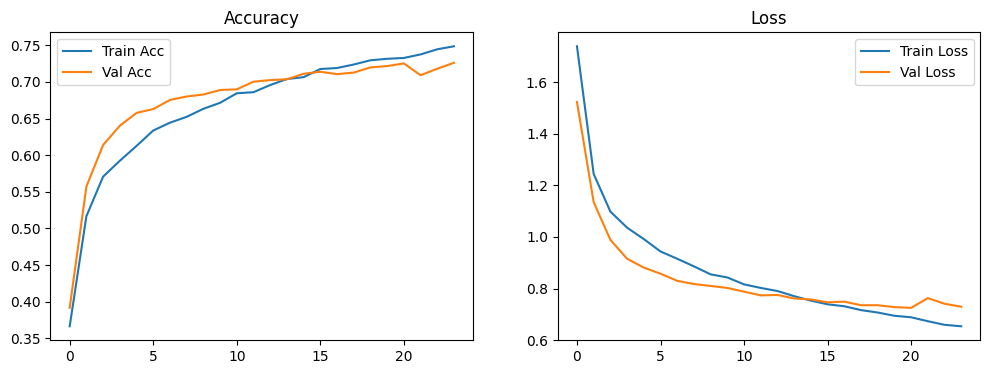

In [12]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()


# 8. Evaluation: Confusion Matrix & Classification Report

In [13]:
y_true = []
y_pred = []

for images, labels in test_prep:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

# Confusion Matrix

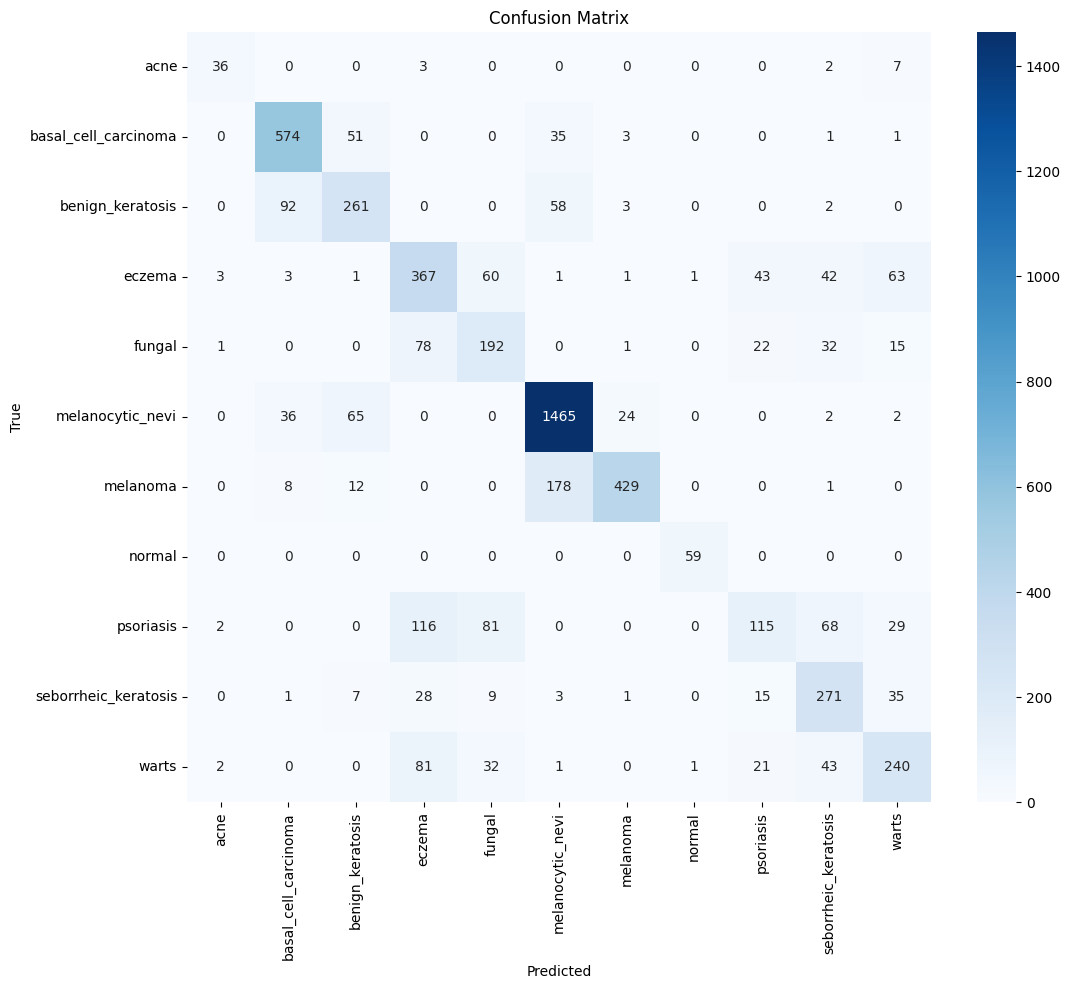

In [14]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# 9. Test Prediction on Random Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted: warts


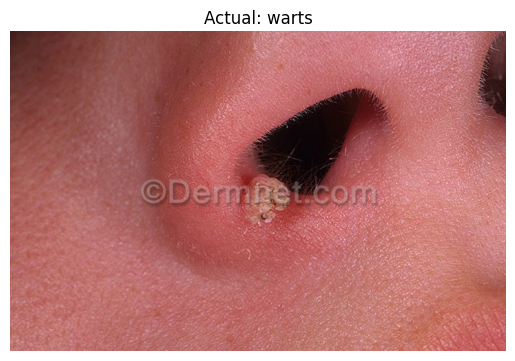

In [15]:
import random
from PIL import Image

test_folder = list(test_dir.glob("*"))

random_class = random.choice(test_folder)
random_image = random.choice(list(random_class.glob("*")))

img = Image.open(random_image)
img_resized = img.resize(IMG_SIZE)

plt.imshow(img)
plt.title(f"Actual: {random_class.name}")
plt.axis("off")

img_array = np.array(img_resized)/255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)[0]
prediction = class_names[np.argmax(pred)]
print("Predicted:", prediction)


# 10. Save Model Final Version

In [16]:
model.save("../models/dermascan_base.h5")


# 11. Retraining Code Block

In [18]:
# Retrain model using new uploaded data

train_prep, test_prep, class_names = train_ds, test_ds, class_names

history_re = model.fit(
    train_prep,
    validation_data=test_prep,
    epochs=5
)

model.save("../models/dermascan_retrained.h5")


Epoch 1/5
738/738 ━━━━━━━━━━━━━━━━━━━━ 165s 223ms/step - accuracy: 0.6828 - loss: 0.8370 - val_accuracy: 0.6396 - val_loss: 0.9223
Epoch 2/5
738/738 ━━━━━━━━━━━━━━━━━━━━ 165s 224ms/step - accuracy: 0.6958 - loss: 0.7970 - val_accuracy: 0.6472 - val_loss: 0.9016
Epoch 3/5
738/738 ━━━━━━━━━━━━━━━━━━━━ 165s 224ms/step - accuracy: 0.7134 - loss: 0.7631 - val_accuracy: 0.6549 - val_loss: 0.8837
Epoch 4/5
738/738 ━━━━━━━━━━━━━━━━━━━━ 165s 224ms/step - accuracy: 0.7263 - loss: 0.7262 - val_accuracy: 0.6566 - val_loss: 0.8793
Epoch 5/5
738/738 ━━━━━━━━━━━━━━━━━━━━ 164s 223ms/step - accuracy: 0.7354 - loss: 0.7022 - val_accuracy: 0.6551 - val_loss: 0.8831
